In [1]:
import torch
import torch.nn as nn # neural network yapısı
import torch.nn.functional as F # activation functions: relu, sigmoid etc.
import torch.utils.data as dt
import torch.optim as optim
from PIL import Image # python image lib for preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os # retrive images from folder
import time # calculate for algorithm running time
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

### NOTE
* Kodu CPU yerine GPU'da daha hızlı çalıştırmak için cuda indirilebiliriz. 
* Aşağıdaki kod satırı çalıştırılarak, **cpu** mu **gpu** mu varsayılan aygıt onu gösterir.
* Bunun için **cuda** yı internetten indirmek gerekir.
* Bu proje için **cuda** gerekli değil.

In [2]:
#%% device configuration OPTIONAL method: DEFAULT CPU but there is also GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## 1-Read Dataset

### NOTE:
Aşağıdaki return edilen array içerisinde:

0. indexinde 1x2048
1. indexinde 1x2048
2. indexinde 1x2048
   
   n. indexinde 1x.2048 tane veri olacaktır.

In [3]:
def read_images(path, num_img):
    array = np.zeros([num_img, 64*32]) # A 64x32 array containing *num_img* data is created, consisting of only 0's. (empty array)
    i = 0
    for img in os.listdir(path): # # loops through directory on given path on os.
        img_path = path + "\\" + img # path=C:\User...\neg + \\ + img=00000.png
        img = Image.open(img_path, mode = "r") # read and open image
        data = np.asarray(img, dtype = "uint8") # convert uint8 as array.
        data = data.flatten() # 64x32 => 1x2048 vectorial 
        array[i,:] = data # add data to row i and all columns in array.
        i += 1
    return array

### A) Read Train Negative(Nonpedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [4]:
with os.scandir('data/Train/neg') as entries:
    for index, entry in enumerate(entries):
        if(index<=5): #
            print(index, entry.name)
print("\nThere are {} images in the specified path.".format(index+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 43390 images in the specified path.


In [5]:
train_negative_path = r"data/Train/neg"
num_train_negative_img = index+1
train_negative_array = read_images(train_negative_path, num_train_negative_img)

In [6]:
print(train_negative_array[0][0])    # first index and first column
print(train_negative_array[0][2047]) # first index and last column

175.0
99.0


### NOTE
- Numpy'da array, torch'ta tensor kullanılır. 1D, 2D, 3D bunların genel ismi tensor'dur.

In [7]:
x_train_negative_tensor = torch.from_numpy(train_negative_array)
print("x_train_negative_tensor:", x_train_negative_tensor.size())
print(x_train_negative_tensor[0][0])    # first index and first column
print(x_train_negative_tensor[0][2047]) # first index and last column

x_train_negative_tensor: torch.Size([43390, 2048])
tensor(175., dtype=torch.float64)
tensor(99., dtype=torch.float64)


### NOTE
- **y_train**'de negativelere yani yaya olmayanlara 0 olarak label, class tanımlaması yaptık.

In [8]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype = torch.long)
print("y_train_negatice_tensor:", y_train_negative_tensor.size())

y_train_negatice_tensor: torch.Size([43390])


### B) Read Train Positive(Pedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [9]:
with os.scandir('data/Train/pos') as entries:
    for index2, entry in enumerate(entries):
        if(index2<=5): #
            print(index2, entry.name)
print("\nThere are {} images in the specified path.".format(index2+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 10208 images in the specified path.


### NOTE
- **y_train**'de positivelere yani yaya olanlara 1 olarak label, class tanımlaması yaptık.

In [10]:
train_positive_path = r"data/Train/pos"
num_train_positive_img = index2+1
train_positive_array = read_images(train_positive_path, num_train_positive_img) 

x_train_positive_tensor = torch.from_numpy(train_positive_array)
print("x_train_positive_tensor:", x_train_positive_tensor.size())

y_train_positive_tensor = torch.ones(num_train_positive_img, dtype = torch.long)
print("y_train_positive_tensor:", y_train_positive_tensor.size())

x_train_positive_tensor: torch.Size([10208, 2048])
y_train_positive_tensor: torch.Size([10208])


### C) Concat images in pos and neg folders.
### NOTE
- The **cat** function is called for concat in Pytorch.
- **Rows** are concatenated with **0** in the code block below.
- If it was 1 instead of **0**, the **columns** would be concatenated. 

In [11]:
x_train = torch.cat((x_train_negative_tensor, x_train_positive_tensor), 0)
y_train = torch.cat((y_train_negative_tensor, y_train_positive_tensor), 0)
print("x_train:", x_train.size())
print("y_train:", y_train.size())

x_train: torch.Size([53598, 2048])
y_train: torch.Size([53598])


### D) Read Test Negative(Nonpedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [12]:
with os.scandir('data/Test/neg') as entries:
    for index3, entry in enumerate(entries):
        if(index3<=5): #
            print(index3, entry.name)
print("\nThere are {} images in the specified path.".format(index3+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 22050 images in the specified path.


### NOTE
- **y_test**'de negative yani yaya olmayanlara 0 olarak label, class tanımlaması yaptık.

In [13]:
test_negative_path = r"data/Test/neg"
num_test_negative_img = index3+1
test_negative_array = read_images(test_negative_path, num_test_negative_img) 

x_test_negative_tensor = torch.from_numpy(test_negative_array)
print("x_test_negative_tensor:", x_test_negative_tensor.size())

y_test_negative_tensor = torch.ones(num_test_negative_img, dtype = torch.long)
print("y_test_negative_tensor:", y_test_negative_tensor.size())

x_test_negative_tensor: torch.Size([22050, 2048])
y_test_negative_tensor: torch.Size([22050])


### E) Read Test Positive(Pedestrian) Files
- Aşağıda kontrol amaçlı ilgili dizinde ilk 5 dosyanın gösterilmiştir.

In [14]:
with os.scandir('data/Test/pos') as entries:
    for index4, entry in enumerate(entries):
        if(index4<=5): #
            print(index4, entry.name)
print("\nThere are {} images in the specified path.".format(index4+1))

0 00000.png
1 00001.png
2 00002.png
3 00003.png
4 00004.png
5 00005.png

There are 5944 images in the specified path.


### NOTE
- **y_test**'de positivelere yani yaya olanlara 1 olarak label, class tanımlaması yaptık.

In [15]:
test_positive_path = r"data/Test/pos"
num_test_positive_img = index4+1
test_positive_array = read_images(test_positive_path, num_test_positive_img) 

x_test_positive_tensor = torch.from_numpy(test_positive_array)
print("x_test_positive_tensor:", x_test_positive_tensor.size())

y_test_positive_tensor = torch.ones(num_test_positive_img, dtype = torch.long)
print("y_test_positive_tensor:", y_test_positive_tensor.size())

x_test_positive_tensor: torch.Size([5944, 2048])
y_test_positive_tensor: torch.Size([5944])


### F) Concat images in pos and neg folders in Test.
### NOTE
- The **cat** function is called for concat in Pytorch.
- **Rows** are concatenated with **0** in the code block below.
- If it was 1 instead of **0**, the **columns** would be concatenated. 

In [16]:
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)
print("x_test:", x_train.size())
print("y_test:", y_train.size())

x_test: torch.Size([53598, 2048])
y_test: torch.Size([53598])


### G) Visualize Data

### NOTE 
- If you are take error, for example, Kernel Died etc, so, you can install **conda install nomkl** command in terminal. 
- If it cannot be installed with this command, it is necessary to **remove** the **mkl package**. 

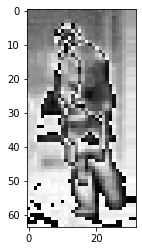

In [17]:
plt.imshow(x_train[45000, :].reshape(64, 32), cmap = "gray")
plt.show()

## 2-Create CNN Model

### A) Defining Hyperparameters

53598 tane veri var, bu sayının bölenleri:
- 1
- 2
- 3
- 6
- 8933
- 17866
- 26799
- 53598
Batch_size train için farklı, test için farklı bunlardan biri seçilir. Memory'ye göre seçilmelidir.

In [18]:
num_epochs = 100
num_classes = 2
batch_size = 6 #train # veri seti size / batch size => kalan 0 olmalı
batch_size_t = 2 #test # veri seti size / batch size => kalan 0 olmalı
learning_rate = 0.00001

### B) Create CNN model class
- Keras'da CNN modelini yaratmak Pytorch'a göre daha kolay denilebilir.

In [19]:
# class Net => CNN class
class Net(nn.Module): # Tüm Neural Network modüllerini inherit eder.(Conv2d, maxPool2d, Linear etc)
    
    def __init__(self): # Constructor
        super(Net, self).__init__() # nn.Module'u inherit edilir.
        
        # input_channels = 3 => rgb, 1 => gray
        # output_channels = 10 => layerdaki nöron sayısı
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5) # 5 => 5x5
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Pencere, her bir boyut boyunca adım adım(stride) kaydırılır.
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = 5) # second hidden layer
        
        # full connected layer(ann)
        self.fc1 = nn.Linear(in_features = 16*13*5, out_features = 520)
        self.fc2 = nn.Linear(in_features = 520, out_features = 130)
        self.fc3 = nn.Linear(in_features = 130, out_features = num_classes)

    # x = input
    def forward(self, x): # Sequential ile aynı mantıkta çalışıyor
        
        # input => conv layer => relu => pooling
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16*13*5) # flatten (-1 ne yazacağımı bilmiyorsam yazarım)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # 3.den sonra relu yok. Kerasta softmax vardı, burada neden yok?
        return x

### C) Merge x and y train/test tensors and convert data

In [20]:
train = dt.TensorDataset(x_train, y_train) # merge x_train and y_train
trainloader = dt.DataLoader(train, batch_size = batch_size, shuffle = True) # train, convert to data.

test = dt.TensorDataset(x_test, y_test) # merge x_test and y_test
testloader = dt.DataLoader(test, batch_size = batch_size_t, shuffle = False)

### D) Create Model and criterion and optimizer

### NOTE
- GPU aktif edildiyse **net = Net().to(device)** run edilerek GPU'da işlemler hızlı bir şekilde gerçekleştirilir.

In [21]:
net = Net() # Crete CNN Model.
# net = Net().to(device) # in GPU

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.8) # momentum=SGD'nin hızlanma parametresi

## 3) Train Data

### A) Define Basic Variables

In [23]:
start = time.time()
train_acc = []
test_acc = []
loss_list = [] # total error (kayıp)
use_gpu = False # True # if we use GPU

In [24]:
for epoch in range(num_epochs): # 100 kez train edilecek.
    for i, data in enumerate(trainloader, 0):
        # inputs = images, labels = 0 or 1
        inputs, labels = data
        inputs = inputs.view(batch_size, 1, 64, 32) # view=reshape, 1=color channel
        inputs = inputs.float() # float
        
        # use gpu
        if use_gpu:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
                
        # zero gradient (türevler her adımda 0'lanmalı)
        optimizer.zero_grad()
        
        # forward (inputs => outputs)
        outputs = net(inputs)
        
        # loss (compare outputs vs labels)
        loss = criterion(outputs, labels)
        
        # back (finding gradient)
        loss.backward()
        
        # update weights
        optimizer.step()
    
    # test
    correct = 0 # correct predict
    total = 0 # total data
    with torch.no_grad(): # back propagation'u kapatıyoruz(train bitti).
        for data in testloader:
            images, labels = data
            
            images = images.view(batch_size_t, 1, 64, 32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images) # outputlar doğru mu yanlış mı acaba?
            
            _, predicted = torch.max(outputs.data,1) # maximum olanlar predictler
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # for int value we use item()
        
    acc1 = 100 * correct / total
    print("accuracy test: ", acc1)
    test_acc.append(acc1)

    # train (train ile predict yapma)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels= data
            
            images = images.view(batch_size, 1, 64, 32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc2 = 100 * correct / total
    print("accuracy train: ", acc2)
    train_acc.append(acc2)

accuracy test:  6.340644423805101
accuracy train:  92.74413224374044
accuracy test:  14.76030577980996
accuracy train:  96.40471659390276
accuracy test:  10.587983139244123
accuracy train:  97.1174297548416
accuracy test:  15.18539687075802
accuracy train:  97.7163326989813
accuracy test:  13.874401657498035
accuracy train:  98.39546251725811
accuracy test:  10.141458884046582
accuracy train:  98.28165230045897
accuracy test:  15.446167035793385
accuracy train:  98.71077279002948
accuracy test:  11.513181396013431
accuracy train:  99.07086085301691
accuracy test:  10.45581195970565
accuracy train:  99.03727751035487
accuracy test:  13.456454954633136
accuracy train:  99.43094891600433
accuracy test:  18.325355433307138
accuracy train:  98.70330982499347
accuracy test:  12.266914338786883
accuracy train:  99.53543042650846
accuracy test:  13.788669000500107
accuracy train:  99.59513414679652
accuracy test:  10.34150175037508
accuracy train:  99.30594425165118
accuracy test:  10.82017575

In [25]:
print("train is done.")

end = time.time()
process_time = (end - start) / 60
print("process time: ", process_time)

train is done.
process time:  162.558222647508


## 4-Visualize Data

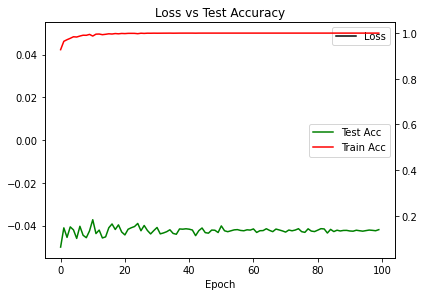

In [26]:
#%% visualize
fig, ax1 = plt.subplots()

plt.plot(loss_list, label = "Loss", color = "black")

ax2 = ax1.twinx()

ax2.plot(np.array(test_acc) / 100, label = "Test Acc", color="green")
ax2.plot(np.array(train_acc) / 100, label = "Train Acc", color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.show()
